In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from matplotlib import cm
import seaborn as sns
from scipy.spatial.distance import euclidean

In [2]:
def poisson(x):
    return -(-x * x) * np.exp(-x)


poisson(1)

0.36787944117144233

In [3]:
def generate_data(x1, x2):
    return -(poisson(x1) + x2 ** (-3 / 2))


n = 10
x1 = np.linspace(1, 5, n)
x2 = np.linspace(1, 8, n)

X1, X2 = np.meshgrid(x1, x2)

y_real = generate_data(X1, X2)
y = generate_data(X1, X2) + [np.random.normal(0, 0.07, n) for i in range(10)]

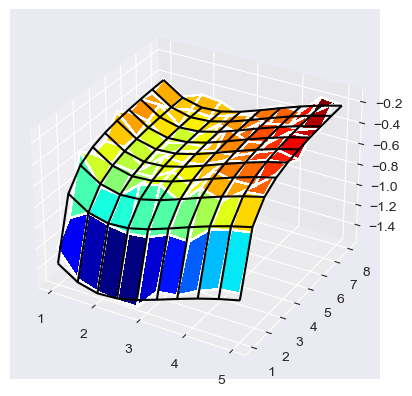

In [4]:
ax = plt.axes(projection='3d')

# ax.view_init(0, 90)
ax.plot_wireframe(X1, X2, y_real, color='black')
ax.plot_surface(X1, X2, y, cmap=cm.jet,
                linewidth=1, antialiased=False)

In [5]:
x1_est = np.linspace(min(x1), max(x1), 80)
x2_est = np.linspace(min(x2), max(x2), 80)
X1_est, X2_est = np.meshgrid(x1_est, x2_est)

In [6]:
kernel_gauss = lambda x: (1.0 / np.sqrt(2 * np.pi)) * np.exp(- 0.5 * np.power(x, 2))

In [7]:
epanechnikov_kernel = lambda u: (3 / 4) * (1 - u ** 2)

In [8]:
triangle_kernel = lambda u: 1 - abs(u)

In [9]:
dist = lambda x, x_i: euclidean(x, x_i)

In [10]:
weight = lambda x, x_i, kernel, h=0.5: kernel(dist(x, x_i) / h)

In [11]:
def nadaraya_watson(x1, x2, x1_est, x2_est, y, h=0.5, kernel=kernel_gauss):
    y_est = []
    n_est = len(x1_est)

    for x1_i in x1_est:
        yy1 = []
        for x2_i in x2_est:
            w = np.array([weight([x1_i, x2_i], [xi_1, xi_2], kernel, h) for xi_1 in x1 for xi_2 in x2])
            yy = np.dot(w, y.reshape(y.size, )) / sum(w)  # формула Надарая-Ватсона
            yy1.append(yy)
        y_est.append(np.array(yy1))
    y_est = np.array(y_est).reshape(n_est, n_est)
    return y_est

In [12]:
y_est = nadaraya_watson(x1, x2, x1_est, x2_est, y)

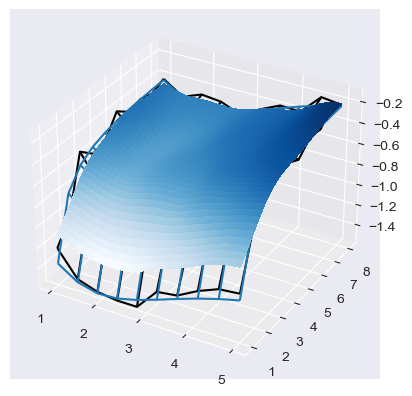

In [37]:
ax = plt.axes(projection='3d')

# ax.view_init(90, 0)
ax.plot_surface(X1_est, X2_est, y_est, cmap=cm.Blues,
                linewidth=0., antialiased=False)
ax.plot_wireframe(X1, X2, y, color='black')
ax.plot_wireframe(X1, X2, y_real)

In [12]:
kernels = [kernel_gauss, triangle_kernel, epanechnikov_kernel]
h_s = np.arange(0.1, 2, 0.25)

In [13]:
def mse(x_real, x_estimate):
    n = len(x_real)
    return np.sqrt(np.sum(np.power(x_real - x_estimate, 2))) / n


def weird_e(x_real, x_estimate):
    n = len(x_real)
    return np.sum(np.abs(x_real - x_estimate)) / (n * (np.max(x_real) - np.min(x_real)))

In [68]:
y_real_interp = generate_data(X1_est, X2_est)

In [80]:
mses = []
weird_es = []
y_ests = []
for h in h_s:
    mses_i = []
    weird_es_i = []
    y_ests_i = []
    for i in range(len(kernels)):
        y_est_i = nadaraya_watson(x1, x2, x1_est, x2_est, y, h, kernels[i])
        y_ests_i.append(y_est_i)
        mses_i.append(mse(y_est_i, y_real_interp))
        weird_es_i.append(weird_e(y_est_i, y_real_interp))

    y_ests.append(y_ests_i)
    mses.append(mses_i)
    weird_es.append(weird_es_i)

In [81]:
mse_df = pd.DataFrame(mses)
mse_df

,0,1,2
0,0.088255,0.271573,0.293792
1,0.048331,0.275422,0.294442
2,0.067792,0.280067,0.295862
3,0.088438,0.285792,0.298164
4,0.107363,0.293044,0.301550
5,0.124751,0.302566,0.306368
6,0.140409,0.315731,0.313229
7,0.154011,0.335472,0.323307


In [82]:
weird_es_df = pd.DataFrame(weird_es)
weird_es_df

,0,1,2
0,8.189281,243.772556,172.894167
1,5.920535,228.732131,171.839880
2,9.425464,213.485262,169.591900
3,14.483365,197.943486,166.098140
4,20.779517,181.939987,161.263719
5,28.624681,165.180006,154.904986
6,38.362957,147.313525,146.535700
7,50.032855,127.052293,135.329441


In [59]:
def stability(arr, eps=1e-5):
    for el in arr:
        if el.any() > eps:
            return True
    return False

In [16]:
def kernel_gamma(z):
    if abs(z) <= 1:
        return (1 - z ** 2) ** 2
    else:
        return 0

In [80]:
def lowess(x, y, h=0.5, f=0.5, kernel=kernel_gauss):
    n = len(x)

    gamma = np.ones(n)
    gamma_old = np.zeros(n)
    yest = np.zeros(n)
    cnt = 0

    while stability(np.abs(gamma - gamma_old)):
        cnt += 1
        w = []
        for t in range(n):
            w.append([])
            for i in range(n):
                w[t].append(weight([x[t]], [x[i]], kernel, h) * gamma[t])
        w = np.array(w)
        yest = (w * y[:, None]).sum(axis=0) / w.sum(axis=0)

        err = np.abs(yest - y)
        gamma = [kernel_gamma(err[j]) for j in range(n)]
        if (cnt > 5):
            break
    return yest

In [71]:
def lowess_3d(x1_est, x2_est, y, h=0.5, kernel=kernel_gauss):
    n = len(x1_est)

    gamma = np.ones(n ** 2)
    gamma_old = np.zeros(n ** 2)
    y_est = []
    cnt = 0

    for t, x1_i in enumerate(x1_est):
        yy1 = []
        for x2_i in x2_est:
            while stability(np.abs(gamma - gamma_old)):
                cnt += 1
                w = np.array([weight([x1_i, x2_i], [xi_1, xi_2], kernel, h) for xi_1 in x1 for xi_2 in x2]) * gamma[t]
                yy = np.dot(w, y.reshape(y.size, )) / sum(w)
                yy1.append(yy)
                y_est.append(np.array(yy1))
                # y_est = np.array(y_est)#.reshape(n, n)

                err = np.abs(y_est - y)
                gamma = [kernel_gamma(err[i][j]) for i in range(n) for j in range(n)]
                if (cnt > 5):
                    break

    # while stability(np.abs(gamma - gamma_old)):
    #     cnt += 1
    #     w = []
    #     for t in range(n):
    #         w.append([])
    #         for i in range(n):
    #             w[t].append(weight([x[t]], [x[i]]) / h) * gamma[t]
    #     w = np.array(w)
    #     yest = (w * y[:, None]).sum(axis=0) / w.sum(axis=0)
    #
    #     err = np.abs(yest - y)
    #     gamma = [kernel_gamma(err[j]) for j in range(n)]
    #     if (cnt > 5):
    #         break
    return y_est

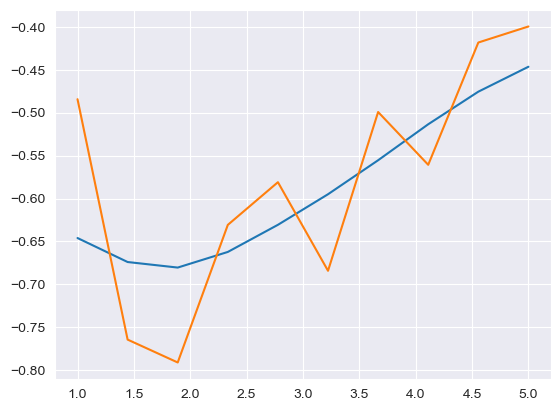

In [86]:
y_est_lowess = lowess(x1, y[2], h = 0.7)
plt.plot(x1, y_est_lowess)
plt.plot(x1, y[2])
# ax = plt.axes(projection='3d')

# ax.view_init(90, 0)
# ax.plot_surface(X1, X2, y_est_lowess, cmap=cm.Blues,
#                 linewidth=0., antialiased=False)
# ax.plot_wireframe(X1, X2, y, color='black')
# ax.plot_wireframe(X1, X2, y_real)